In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from denn import *
import torch
from torch import nn, functional as F

In [2]:
path = Path('../data/large')

In [3]:
ab = pd.read_csv(path/'dC_01.csv', header=None).values[0]
bestKnow = pd.read_csv(path/'Best_Know1Fxs.csv', header=None).values[0]
bestKnow = bestKnow[:100].astype(float)
java_results = pd.read_csv(path/'Feasibility1Fs.csv', header=None).values[0]
java_results = java_results[:-1].astype(float)
java_results_all = pd.read_csv(path/'Feasibility1Fs.csv', header=None).iloc[:,:-1]

In [4]:
D = 30
nn_window = 5
nn_nf = 4
frequency = 1_000
max_times = len(ab)
total_generations = max_times * frequency + 1000

In [5]:
class SimpleModel(nn.Module):
    def __init__(self, d=D, w=nn_window, nf=nn_nf):
        super().__init__()
        self.fc1 = nn.Linear(d,nf)
        self.fc2 = nn.Linear(nf*w,d)
        self.act = nn.ReLU(inplace=True)
        
    def forward(self, x):
        fts = torch.cat([self.fc1(x[:,i]) for i in range(x.size(1))], dim=1)
        return self.fc2(self.act(fts))

model = SimpleModel()

In [6]:
def fitness_func(indiv): return (indiv.data**2).sum()
def constraint_func(indiv, b): return -b + sum((1/np.sqrt(D))*indiv.data)

population = Population.new_random(dimension=D)
nn_trainer = partial(NNTrainer, model=model, window=nn_window)
opt = Optimization(population, fitness_func, constraint_func, constraint_params=[ab],
                   max_times=max_times, frequency=frequency,
                   callbacks=[DynamicConstraint,nn_trainer])
opt.state_dict

{'gen': 0, 'evals': 0, 'time': 0, 'best': None}

A proper report should be shown here :)
Total time: 00:31


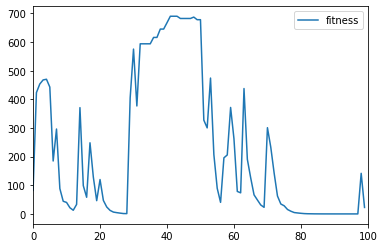

In [7]:
opt.run(total_generations)

In [8]:
pred = opt.nn_trainer.get_next_best()
pred

tensor([ 0.4977,  0.4200,  0.0546, -0.4476,  0.0605, -0.7421,  0.0239,  0.5881,
        -0.4805, -0.7313, -0.4238, -0.5188, -0.8379,  0.0744, -1.1047, -0.5437,
         0.3697,  0.3809,  0.0093, -0.9726,  0.1272,  0.7253, -0.3169, -0.6255,
        -0.5647,  0.9024, -0.6051, -0.0537, -1.4010,  0.1762])

In [13]:
fitness_func(opt.best), fitness_func(pred)

(22.588099, tensor(10.7240))

In [14]:
constraint_func(opt.best, ab[-1]), constraint_func(pred, ab[-1])

(-16.83080622751126, tensor(-18.3321))

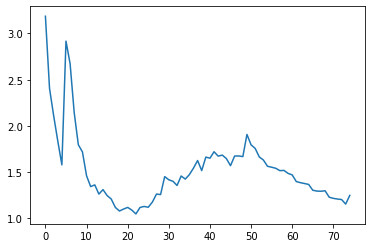

In [15]:
plt.plot(opt.nn_trainer.train_losses)

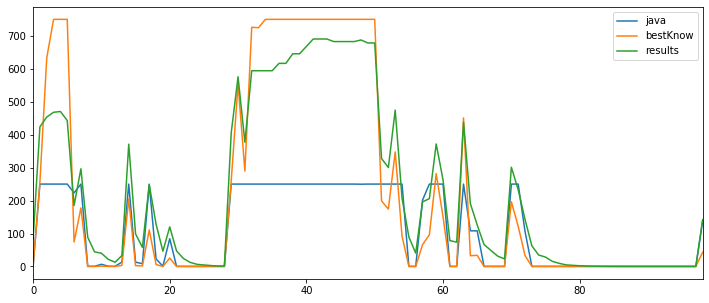

In [16]:
df = pd.DataFrame({'java':java_results, 'bestKnow':bestKnow[:-1], 'results': opt.recorder.best_times_fitness[:-1]})
df.plot(figsize=(12,5));